In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
#from itertools import permutations
from collections import Counter
from math import ceil
import pingouin as pg
import statsmodels.api as sm
from scipy.stats import ks_2samp
from scipy.stats import rankdata
from scipy.special import softmax

import os
from sklearn.preprocessing import RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import power_transform

from stargazer.stargazer import Stargazer

## Data

In [2]:
#years = [y for y in range(2000, 2022)]

In [3]:
# years

In [4]:
def get_variables(from_, to_, incl_rect=True):
    
    years = [y for y in range(from_, to_+1)]
    
    variables = [f"frq_{y}" for y in years]
    variables.extend([f"fpm_{y}" for y in years])
    variables.extend([f"gch_{y}:{y+1}" for y in years[:-1]])
    if incl_rect:
        variables.extend([f"rch_{y}:{y+1}" for y in years[:-1]])
    
    years = [str(y) for y in years]
    
    return variables, years

In [5]:
#variables

In [6]:
# redefine years
#years = [str(y) for y in years]

In [7]:
terms = [
'N1_kulturberikare',
'V1_berika',
'N1_berikare',
'N1_globalist',
'V1_kulturberika',
'N1_återvandring',
'V1_återvandra',
'A1_globalistisk',
'N1_förortsgäng',
]

In [8]:
def get_df(path, variables, terms, min_freq=10, drop_frq=True):
    df = pd.read_csv(Path(path), sep=";", index_col = 0)
    terms = [t for t in terms if t in df.index]
    #print(terms)
    df = df[variables]
    df = df.loc[terms]
    
    if min_freq != None:
        years = [col.split("_")[-1] for col in df.columns if col.startswith("frq_")]
        for dwe in df.index:
            for year in years:
                if df.loc[dwe][f"frq_{year}"] < min_freq: 
                    df.at[dwe, f"fpm_{year}"] = np.nan
                    
                    if year == max(years):
                        df.at[dwe, f"gch_{int(year)-1}:{year}"] = np.nan
                        df.at[dwe, f"rch_{int(year)-1}:{year}"] = np.nan
                    else:
                        df.at[dwe, f"gch_{year}:{int(year)+1}"] = np.nan
                        df.at[dwe, f"rch_{year}:{int(year)+1}"] = np.nan
    
    if drop_frq:
        df.drop([col for col in df.columns if col.startswith("frq_")], axis=1, inplace=True)

    return df

In [9]:
def get_iod(path, ref_path, variables, terms, min_freq=10):
    
    df = pd.read_csv(path, index_col=0)
    
    #print("Years in IOD data:", list(df.columns))
    
    ref = get_df(ref_path, variables, terms, min_freq = None, drop_frq=False)
    
    years = [col.split("_")[-1] for col in ref.columns if col.startswith("frq_")]
    
    #print("Years in LSC data:", years)
    
    if min_freq != None:
        for dwe in ref.index:
            for year in years:
                if ref.loc[dwe][f"frq_{year}"] < min_freq:
                    df.loc[df["DWE"] == dwe, year] = np.nan    
                    
    return df


### Change and FPM

#### Flashback

In [10]:
variables, years = get_variables(2000, 2022)
# variables, years = get_variables(2000, 2021) # <-- Obs!

sgns_lsc = get_df(
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted.csv", 
    variables, 
    terms,
    drop_frq = False
)
kb_lsc   = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
                  variables, 
                  terms)
sts_lsc  = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sts_fbmodel.csv", 
                  variables, 
                  terms)

In [11]:
years

['2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022']

#### Familjeliv

In [12]:
fm_variables, fm_years = get_variables(2003, 2022)
# fm_variables, fm_years = get_variables(2003, 2021) # <-- Obs!

fm_sgns_lsc = get_df("/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted.csv", fm_variables, terms)
fm_kb_lsc   = get_df("/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-sentence-bert-swedish-cased.csv", fm_variables, terms)

In [13]:
fm_years

['2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022']

### Ingroup--Outgroup Dimension

In [14]:
os.listdir("/home/max/Results/replacements/results/")

['sts_results.csv',
 'fm_sgns_results.csv',
 'kb_results.csv',
 'fm_kb_results.csv',
 'sgns_results.csv']

#### Flashback

In [15]:
sgns_iod = get_iod(
    "/home/max/Results/replacements/results/sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted.csv", 
    variables, 
    terms
)
sgns_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True)

In [16]:
kb_iod = get_iod(
    "/home/max/Results/replacements/results/kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

In [17]:
sts_iod = get_iod(
    "/home/max/Results/replacements/results/sts_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

In [18]:
# sgns_iod = pd.read_csv("/home/max/Results/replacements/results/sgns_results.csv", index_col=0)
# sgns_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True)
# kb_iod   = pd.read_csv("/home/max/Results/replacements/results/kb_results.csv", index_col=0)
# sts_iod  = pd.read_csv("/home/max/Results/replacements/results/sts_results.csv", index_col=0)
# #sts_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True)

In [19]:
sgns_iod

,DWE,A-Strategy,B-Strategy,Method,2000,2001,2002,2003,2004,2005,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,V1_berika,top3,lazy,I-cnt,0.986395,0.715155,0.818471,0.853153,0.696961,0.619241,...,0.353835,0.316448,0.357412,0.414762,0.378341,0.367202,0.375845,0.374658,0.390267,0.398719
1,V1_berika,top3,lazy,O-cnt,0.969148,0.686442,0.790991,0.829854,0.693168,0.605649,...,0.354648,0.311637,0.361755,0.339383,0.280309,0.291818,0.348174,0.330762,0.399016,0.344857
2,V1_berika,top3,lazy,cnt-ssc,0.504410,0.510243,0.508537,0.506922,0.501364,0.505548,...,0.499426,0.503830,0.496980,0.549976,0.574419,0.557194,0.519110,0.531113,0.494457,0.536218
3,V1_berika,top3,lazy,cnt-smx,0.504312,0.507178,0.506870,0.505824,0.500948,0.503398,...,0.499797,0.501203,0.498914,0.518836,0.524488,0.518837,0.506917,0.510972,0.497813,0.513462
4,V1_berika,top3,lazy,I-pwn,0.982027,0.698244,0.772756,0.791636,0.594525,0.472354,...,0.260455,0.229991,0.263792,0.296300,0.270373,0.269239,0.269341,0.263698,0.280599,0.287643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,N1_förortsgäng,ms1,min0.2,cnt-smx,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.484448,0.488332,0.506825,0.515285,0.494516,0.503283,NaN,0.489880,0.488751
572,N1_förortsgäng,ms1,min0.2,I-pwn,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.455653,0.471425,0.505860,0.516324,0.429436,0.492266,NaN,0.520405,0.491884
573,N1_förortsgäng,ms1,min0.2,O-pwn,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.442385,0.447575,0.428776,0.410907,0.406426,0.428552,NaN,0.468478,0.449418
574,N1_förortsgäng,ms1,min0.2,pwn-ssc,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.507387,0.512976,0.541237,0.556845,0.513764,0.534596,NaN,0.526256,0.522557


### Why does not min_freq work properly???

Helt obegripligt!!

In [20]:
pd.set_option('display.max_columns', None)

In [21]:
columns = [col for col in sgns_iod.columns if ":" not in col]
mamma = sgns_iod.copy()
mamma = mamma[mamma["A-Strategy"]=="top3"]
mamma = mamma[mamma["B-Strategy"]=="lazy"]
mamma = mamma[mamma["Method"]=="I-cnt"]
mamma.drop(columns=["A-Strategy", "B-Strategy", "Method"], inplace=True)
mamma.set_index("DWE", inplace=True)
mamma = mamma[years].sort_index()
mamma.round(2)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
DWE,,,,,,,,,,,,,,,,,,,,,,,
A1_globalistisk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0.50,0.54,0.50,0.55,0.59,0.56,0.55,0.57,0.54,0.60,0.59,0.60,0.58,0.57
N1_berikare,0.92,NaN,NaN,NaN,NaN,NaN,0.48,0.28,0.23,0.27,0.29,0.33,0.28,0.21,0.23,0.17,0.29,0.26,0.27,0.28,0.24,0.25,0.25
N1_förortsgäng,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.36,NaN,NaN,NaN,NaN,0.44,0.40,0.44,0.43,0.39,0.49,NaN,0.47,0.42
N1_globalist,NaN,NaN,NaN,NaN,NaN,0.49,0.36,0.44,0.55,0.54,0.52,0.58,0.58,0.57,0.59,0.62,0.71,0.70,0.75,0.70,0.72,0.71,0.68
N1_kulturberikare,0.95,0.83,NaN,NaN,0.78,0.53,0.40,0.23,0.30,0.27,0.26,0.28,0.27,0.29,0.30,0.24,0.21,0.20,0.31,0.23,0.23,0.30,0.30
N1_återvandring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.52,0.55,0.52,0.54,0.58,0.58,0.60,0.60,0.56,0.59,0.53,0.61,0.62,0.62,0.62,0.62
V1_berika,0.99,0.72,0.82,0.85,0.70,0.62,0.43,0.35,0.36,0.30,0.30,0.36,0.32,0.35,0.32,0.36,0.41,0.38,0.37,0.38,0.37,0.39,0.40
V1_kulturberika,NaN,NaN,NaN,NaN,NaN,NaN,0.34,0.22,0.18,0.25,0.25,0.23,0.29,0.23,0.24,0.22,0.27,0.27,0.26,0.25,0.28,0.31,0.33
V1_återvandra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,0.50,0.47,0.53,0.48,0.49,0.49,0.47,0.44,0.41,0.41,0.50,0.55,0.52,0.57,0.54


In [22]:
mu = sgns_lsc[[col for col in sgns_lsc if col.startswith("frq")]].sort_index()
mu.rename(columns={col:col.split("_")[-1] for col in mu.columns}).astype(int)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
A1_globalistisk,0,0,0,0,0,0,0,0,38,53,66,132,247,209,248,164,306,484,736,804,701,563,709
N1_berikare,21,0,0,0,0,0,20,213,650,666,497,413,426,276,202,216,153,125,143,142,88,33,33
N1_förortsgäng,0,0,0,0,0,0,0,0,0,19,0,0,0,14,25,18,12,14,24,29,11,21,40
N1_globalist,0,0,0,0,0,24,43,32,314,244,326,444,824,888,872,801,2079,2802,4734,4137,3728,3336,5528
N1_kulturberikare,45,28,10,0,36,24,76,307,777,605,1104,611,596,470,208,144,190,114,243,197,100,128,120
N1_återvandring,0,0,0,0,0,0,30,66,143,75,203,55,185,222,190,149,210,183,3942,1704,1484,1855,2303
V1_berika,43,22,30,23,77,88,276,703,1509,1995,2087,2011,1661,1390,1183,1231,1351,866,1037,1081,841,646,785
V1_kulturberika,0,0,0,0,0,12,20,149,238,262,330,269,259,205,116,129,109,60,74,63,67,47,36
V1_återvandra,0,0,0,0,0,0,10,26,23,34,51,36,44,64,47,30,21,27,310,144,141,209,232


In [23]:
kb_iod

,DWE,A-Strategy,Method,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,V1_berika,rn,I-cnt,0.508248,0.527463,0.549233,0.468585,0.525115,0.492592,0.509649,0.541307,0.541685,0.560794,0.543517,0.547380,0.542689,0.527732,0.548054,0.544408,0.562724,0.552851,0.535919,0.545333,0.528533,0.523378,0.525707
1,V1_berika,rn,O-cnt,0.668657,0.562767,0.688737,0.624902,0.632582,0.627013,0.635394,0.687490,0.678552,0.696306,0.692080,0.678996,0.683485,0.680976,0.694471,0.678219,0.701206,0.664811,0.651067,0.664717,0.622969,0.628794,0.620463
2,V1_berika,rn,cnt-ssc,0.431852,0.483809,0.443656,0.428524,0.453586,0.439969,0.445092,0.440518,0.443918,0.446101,0.439882,0.446339,0.442587,0.436608,0.441081,0.445277,0.445218,0.454027,0.451496,0.450670,0.458995,0.454253,0.458664
3,V1_berika,rn,cnt-smx,0.459984,0.491175,0.465180,0.461000,0.473159,0.466445,0.468605,0.463519,0.465836,0.466174,0.462927,0.467143,0.464859,0.461764,0.463461,0.466597,0.465435,0.472039,0.471245,0.470189,0.476409,0.473670,0.476329
4,V1_berika,rn,I-pwn,0.352091,0.364761,0.378151,0.314721,0.360003,0.334131,0.345811,0.369264,0.369521,0.386600,0.370997,0.373782,0.370495,0.358195,0.375517,0.371985,0.387186,0.377279,0.364415,0.373294,0.361513,0.357384,0.359206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,N1_förortsgäng,ms1,cnt-smx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.467386,NaN,NaN,NaN,0.481188,0.470848,0.462482,0.473469,0.458560,0.470052,0.451820,0.460001,0.458607,0.476498
356,N1_förortsgäng,ms1,I-pwn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.547310,NaN,NaN,NaN,0.503919,0.568998,0.577857,0.602486,0.495024,0.505721,0.503065,0.555831,0.480534,0.528982
357,N1_förortsgäng,ms1,O-pwn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.597998,NaN,NaN,NaN,0.515349,0.606875,0.642625,0.628526,0.581065,0.553796,0.608979,0.630193,0.566998,0.552990
358,N1_förortsgäng,ms1,pwn-ssc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.477871,NaN,NaN,NaN,0.494393,0.483894,0.473466,0.489423,0.460021,0.477313,0.452379,0.468651,0.458730,0.488905


#### Familjeliv

In [24]:
fm_sgns_iod = get_iod(
    "/home/max/Results/replacements/results/fm_sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted.csv", 
    fm_variables, 
    terms
)

In [25]:
fm_kb_iod   = get_iod(
    "/home/max/Results/replacements/results/fm_kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-sentence-bert-swedish-cased.csv", 
    fm_variables, 
    terms
)

In [26]:
# fm_sgns_iod = pd.read_csv("/home/max/Results/replacements/results/fm_sgns_results.csv", index_col=0)
# fm_kb_iod   = pd.read_csv("/home/max/Results/replacements/results/fm_kb_results.csv", index_col=0)

#### Re-Run Globalist

In [27]:
os.listdir("/home/max/Results/rplc_globalist_2nd_round/results")

['fl_globalist_kb_results.csv',
 'fb_globalist_sgns_results.csv',
 'fb_globalist_sts_results.csv',
 'fb_globalist_kb_results.csv',
 'fl_globalist_sgns_results.csv']

In [28]:
fb_sgns_G_iod = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fb_globalist_sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted.csv", 
    variables, 
    terms
)
fb_sgns_G_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

fb_kb_G_iod   = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fb_globalist_kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

fb_sts_G_iod  = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fb_globalist_sts_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

fm_sgns_G_iod = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fl_globalist_sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted.csv", 
    fm_variables, 
    terms
)

fm_kb_G_iod     = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fl_globalist_kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-sentence-bert-swedish-cased.csv", 
    fm_variables, 
    terms
)

#### With Global Initialization NLPL

In [29]:
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)

sgns_lsc_nlpl = get_df(
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w_glob_nlpl.csv", 
    variables_noRCH, 
    terms,
    drop_frq = False
)

fb_sgns_iod_nlpl = get_iod(
    "/home/max/Results/rplc_w-global-nlpl/results/sgns-w-global-nlpl_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w_glob_nlpl.csv", 
    variables_noRCH, 
    terms
)
fb_sgns_iod_nlpl.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

#### Different window sizes

In [30]:
WS=5
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
sgns_lsc_w5 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w5_iod = get_iod(f"/home/max/Results/rplc_w{WS}/results/fb_sgns-w{WS}_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms)
fb_sgns_w5_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [31]:
WS=10
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
sgns_lsc_w10 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w10_iod = get_iod(f"/home/max/Results/rplc_w{WS}/results/fb_sgns-w{WS}_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms)
fb_sgns_w10_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [32]:
WS=15
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
sgns_lsc_w15 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w15_iod = get_iod(f"/home/max/Results/rplc_w{WS}/results/fb_sgns-w{WS}_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms)
fb_sgns_w15_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

#### 200 dimensions

In [33]:
WS=5
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
sgns_lsc_w5_200 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w5_200_iod = get_iod(f"/home/max/Results/rplc_w{WS}-200/results/fb_sgns-w{WS}-200_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms)
fb_sgns_w5_200_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [35]:
WS=10
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
sgns_lsc_w10_200 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w10_200_iod = get_iod(f"/home/max/Results/rplc_w{WS}-200/results/fb_sgns-w{WS}-200_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms)
fb_sgns_w10_200_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [36]:
WS=15
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
sgns_lsc_w15_200 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w15_200_iod = get_iod(f"/home/max/Results/rplc_w{WS}-200/results/fb_sgns-w{WS}-200_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms)
fb_sgns_w15_200_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [ ]:
# sgns_lsc_w15
# fb_sgns_w15_iod

### Know your data

In [ ]:
sgns_iod

In [ ]:
sgns_iod[(sgns_iod["DWE"] == "V1_berika") & ((sgns_iod["Method"] == "cnt-ssc") | (sgns_iod["Method"] == "cnt-smx"))]

In [ ]:
set(sgns_iod["DWE"].values)

In [ ]:
fm_sgns_iod

In [ ]:
set(fm_sgns_lsc.index)

### Add IOD difference

Consider using absulte values

In [37]:
def add_iod_dif(df, years):
    transitions = [(y, str(int(y)+1)) for y in years[:-1]]
    df = df.copy()
    for yi, yj in transitions:
#         df[f"{yi[2:]}:{yj[2:]}"] = abs(df[f"{yj}"] - df[f"{yi}"])
#         df[f"{yi}:{yj}"] = abs(df[f"{yj}"] - df[f"{yi}"])
        df[f"{yi}:{yj}"] = df[f"{yj}"] - df[f"{yi}"]

    return df

In [38]:
sgns_iod      = add_iod_dif(sgns_iod, years)
kb_iod        = add_iod_dif(kb_iod, years)
sts_iod       = add_iod_dif(sts_iod, years)

fb_sgns_G_iod = add_iod_dif(fb_sgns_G_iod, years)
fb_kb_G_iod   = add_iod_dif(fb_kb_G_iod, years)
fb_sts_G_iod  = add_iod_dif(fb_sts_G_iod, years)

fm_sgns_iod   = add_iod_dif(fm_sgns_iod, fm_years)
fm_kb_iod     = add_iod_dif(fm_kb_iod, fm_years)

fm_sgns_G_iod = add_iod_dif(fm_sgns_G_iod, fm_years)
fm_kb_G_iod   = add_iod_dif(fm_kb_G_iod, fm_years)

fb_sgns_iod_nlpl = add_iod_dif(fb_sgns_iod_nlpl, years)

fb_sgns_w5_iod  = add_iod_dif(fb_sgns_w5_iod, years)
fb_sgns_w10_iod = add_iod_dif(fb_sgns_w10_iod, years)
fb_sgns_w15_iod = add_iod_dif(fb_sgns_w15_iod, years)

fb_sgns_w5_200_iod  = add_iod_dif(fb_sgns_w5_200_iod, years)
fb_sgns_w10_200_iod  = add_iod_dif(fb_sgns_w10_200_iod, years)
fb_sgns_w15_200_iod  = add_iod_dif(fb_sgns_w15_200_iod, years)

In [ ]:
fb_sgns_iod_nlpl

## Regression

In [ ]:
sgns_iod

In [ ]:
sgns_lsc.columns

In [39]:
def data2data(
    iod_data, 
    lsc_data, 
    dwes, 
    AB_strat, 
    years, 
    methods, 
    baseline="first", 
    add_log_fpm=True, 
    add_freq_dif=True
):
    
    df = iod_data.copy()
    
    df = df[df["DWE"].isin(dwes)]

    assert type(AB_strat) == dict
        
    for var, val in AB_strat.items():
        df = df[df[var]==val]
    
    df.drop(AB_strat.keys(), axis=1, inplace=True)
    
    transitions = [(year, str(int(year)+1)) for year in years[:-1]]
    
    lscs = ["fpm", "gch", "rch"]
    if add_freq_dif:
        lscs = lscs + ["fdf", "adf", "fpc", "apc"]
        lsc_data = lsc_data.copy()
        for yi, yj in transitions:
            lsc_data[f"fdf_{yi}:{yj}"] = lsc_data[f"fpm_{yj}"] - lsc_data[f"fpm_{yi}"] 
        for yi, yj in transitions:
            lsc_data[f"adf_{yi}:{yj}"] = abs(lsc_data[f"fpm_{yj}"] - lsc_data[f"fpm_{yi}"]) 
        for yi, yj in transitions:
            lsc_data[f"fpc_{yi}:{yj}"] = (lsc_data[f"fpm_{yj}"] - lsc_data[f"fpm_{yi}"]) / lsc_data[f"fpm_{yi}"]
        for yi, yj in transitions:
            lsc_data[f"apc_{yi}:{yj}"] = abs((lsc_data[f"fpm_{yj}"] - lsc_data[f"fpm_{yi}"]) / lsc_data[f"fpm_{yi}"])
        
    
#     transitions = [f"{year[2:]}:{str(int(year)+1)[2:]}" for year in years[:-1]]
    transitions = [f"{yi}:{yj}" for yi, yj in transitions]

    
    if baseline == "first":
        years = years[:-1]
    if baseline == "second":
        years = years[1:]
        
#     return [dw for lst in [[dw]*len(years) for dw in [df[df["Method"]=="I-cnt"]["DWE"]]] for dw in lst]

#     return df[df["Method"]=="I-cnt"][["DWE"]+years].set_index("DWE").sort_index()

    new_df = []
    dw_yrs = []
    for method in methods:
        s    = df[df["Method"]==method][["DWE"]+years].set_index("DWE").sort_index()
        idx  = [dw for lst in [[dw]*len(years) for dw in s.index] for dw in lst]
        yrs  = years*len(s.index)
        dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, yrs)], name=method))
        new_df.append(pd.Series(s.to_numpy().flatten(), name=method))
        
    for method in methods: 
        s   = df[df["Method"]==method][["DWE"]+transitions].set_index("DWE").sort_index()
        idx = [dw for lst in [[dw]*len(transitions) for dw in s.index] for dw in lst]
        trs  = transitions*len(s.index)
        dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, trs)], name=method+"_dif"))
        new_df.append(pd.Series(s.to_numpy().flatten(), name=method+"_dif"))
    
    for lsc_measure in lscs:
        if lsc_measure == "fpm":
            variables = [col for col in lsc_data.columns if col.startswith("fpm") and col.split("_")[-1] in years]
            s = lsc_data.loc[dwes][variables].sort_index()
            idx  = [dw for lst in [[dw]*len(years) for dw in s.index] for dw in lst]
            yrs  = years*len(s.index)
            dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, yrs)], name=lsc_measure))
            new_df.append(pd.Series(s.to_numpy().flatten(), name=lsc_measure))
            if add_log_fpm:
                new_df.append(pd.Series(np.log10(s.to_numpy().flatten()), name=lsc_measure+"_log"))
            
        else:
            variables = [col for col in lsc_data.columns if col.startswith(lsc_measure)]
            s = lsc_data.loc[dwes][variables].sort_index()
            idx = [dw for lst in [[dw]*len(transitions) for dw in s.index] for dw in lst]
            trs  = trs*len(s.index)
            dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, trs)], name=lsc_measure))
            new_df.append(pd.Series(s.to_numpy().flatten(), name=lsc_measure))
    
    check = pd.concat(dw_yrs, axis=1)
    
    if False in (check[methods].eq(check["fpm"], axis=0)).all(axis=1):
        print("No match")
    
    if False in (check[[col for col in check.columns if col.endswith("dif")]].eq(check[["gch","rch"]], axis=0)).all(axis=1):
        print("No match")
        
    data = pd.concat(new_df+[check["fpm"].rename("DW-YR")], axis=1)
    
    return data


In [40]:
def OLS(data, DEP, INDEP, transform_dep=False, dep_transformer=None): 
    
    df = data[[DEP]+INDEP].copy()
    df = df.dropna(axis=0)
    
    X = df[INDEP]
    y = df[DEP]
    
    if transform_dep: 
        if dep_transformer == None:
            y = np.log10(y)
        elif dep_transformer == "rank":
            y = rankdata(y)
        else:
            y = y.values.reshape(-1,1)
            if dep_transformer == "box-cox":
                transformer = PowerTransformer(method='box-cox')
                y = transformer.fit_transform(y)
                #y = power_transform(y, method='box-cox')
                print("Lambda = ", transformer.lambdas_[0])
            elif dep_transformer == "yeo-johnson":
                y = power_transform(y, method='yeo-johnson')
            else:
                transformer = dep_transformer
                y = transformer.fit_transform(y)

    X = sm.add_constant(X)

    model = sm.OLS(y, X, missing="drop").fit()

    return model

In [41]:
def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    return s

### SGNS

In [100]:
iod_var = "cnt-ssc_dif"
indep = [
    iod_var, 
    "fpc", 
    #"fpm_rnk",
    "fpm_log",
#     "fpm"
]
dep="gch"

In [92]:
DWE      = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng']
ABSTRAT  = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}
YEARS    = years
METHODS  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"]
BASELINE = "first"

##### W5, dim200

In [101]:
data = data2data(
    iod_data = fb_sgns_w5_200_iod, 
    lsc_data = sgns_lsc_w5_200, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

trim=False
if trim:
    Q=0.75
    for v in indep+[dep]:
        q75 = data[v].quantile(q=Q)
        data[v] = data[v].apply(lambda x: x if x<q75 else q75)

res_sgns_w5_200 = OLS(data, "gch", indep, transform_dep=True)#, dep_transformer="box-cox" )
res_sgns_w5_200.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     8.128
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           0.000126
Time:                        06:29:53   Log-Likelihood:                 58.100
No. Observations:                  64   AIC:                            -108.2
Df Residuals:                      60   BIC:                            -99.56
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.8728      0.027    -32.914      0.000      -0.926      -0.820
cnt-ssc_dif     1.5221      0.584      2.607      0.012       0.354       2.690
fpc             0.0139      0.006      2.338      0.023       0.002       0.026
fpm_log         0.0640      0.018      3.632      0.001       0.029       0.099
==============================================================================
Omnibus:                        3.185   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.639
Skew:                          -0.211   Prob(JB):                        0.267
Kurtosis:                       3.901   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: >

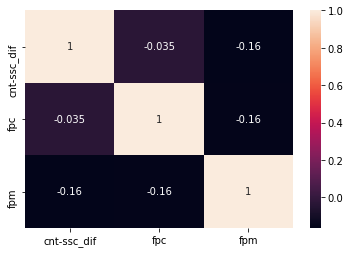

In [88]:
sns.heatmap(data[indep].corr(), annot=True)

##### W10, dim200

In [102]:
data = data2data(
    iod_data = fb_sgns_w10_200_iod, 
    lsc_data = sgns_lsc_w10_200, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

trim=False
if trim:
    Q=0.75
    for v in indep+[dep]:
        q75 = data[v].quantile(q=Q)
        data[v] = data[v].apply(lambda x: x if x<q75 else q75)

res_sgns_w10_200 = OLS(data, "gch", indep, transform_dep=True)#, dep_transformer="box-cox" )
res_sgns_w10_200.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     4.659
Date:                Thu, 14 Mar 2024   Prob (F-statistic):            0.00541
Time:                        06:29:59   Log-Likelihood:                 58.001
No. Observations:                  64   AIC:                            -108.0
Df Residuals:                      60   BIC:                            -99.37
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.7992      0.024    -32.631      0.000      -0.848      -0.750
cnt-ssc_dif     1.0179      0.586      1.737      0.088      -0.154       2.190
fpc             0.0105      0.006      1.766      0.083      -0.001       0.022
fpm_log         0.0450      0.018      2.467      0.016       0.009       0.081
==============================================================================
Omnibus:                        2.347   Durbin-Watson:                   1.475
Prob(Omnibus):                  0.309   Jarque-Bera (JB):                1.551
Skew:                          -0.312   Prob(JB):                        0.461
Kurtosis:                       3.438   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### W15, dim200

In [103]:
data = data2data(
    iod_data = fb_sgns_w15_200_iod, 
    lsc_data = sgns_lsc_w15_200, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

trim=False
if trim:
    Q=0.75
    for v in indep+[dep]:
        q75 = data[v].quantile(q=Q)
        data[v] = data[v].apply(lambda x: x if x<q75 else q75)

res_sgns_w15_200  = OLS(data, "gch", indep, transform_dep=True)#, dep_transformer="box-cox" )
res_sgns_w15_200.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     6.889
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           0.000461
Time:                        06:30:12   Log-Likelihood:                 62.817
No. Observations:                  64   AIC:                            -117.6
Df Residuals:                      60   BIC:                            -109.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.8037      0.024    -33.742      0.000      -0.851      -0.756
cnt-ssc_dif     1.6380      0.528      3.103      0.003       0.582       2.694
fpc             0.0101      0.006      1.822      0.073      -0.001       0.021
fpm_log         0.0389      0.017      2.345      0.022       0.006       0.072
==============================================================================
Omnibus:                        4.937   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.277
Skew:                          -0.429   Prob(JB):                        0.118
Kurtosis:                       3.932   Cond. No.                         99.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### NLPL-init vectors

In [104]:
data = data2data(
    iod_data = fb_sgns_iod_nlpl, 
    lsc_data = sgns_lsc_nlpl, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

trim=False
if trim:
    Q=0.75
    for v in indep+[dep]:
        q75 = data[v].quantile(q=Q)
        data[v] = data[v].apply(lambda x: x if x<q75 else q75)

res_sgns_nlpl = OLS(data, "gch", indep, transform_dep=True)#, dep_transformer="box-cox" )
res_sgns_nlpl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3.249
Date:                Thu, 14 Mar 2024   Prob (F-statistic):             0.0279
Time:                        06:30:27   Log-Likelihood:                 53.062
No. Observations:                  64   AIC:                            -98.12
Df Residuals:                      60   BIC:                            -89.49
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.8370      0.027    -31.228      0.000      -0.891      -0.783
cnt-ssc_dif     1.6059      0.708      2.269      0.027       0.190       3.022
fpc             0.0137      0.006      2.120      0.038       0.001       0.027
fpm_log        -0.0109      0.020     -0.556      0.581      -0.050       0.028
==============================================================================
Omnibus:                        3.247   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                2.621
Skew:                           0.246   Prob(JB):                        0.270
Kurtosis:                       3.860   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Original models

In [105]:
data = data2data(
    iod_data = sgns_iod, 
    lsc_data = sgns_lsc, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

trim=False
if trim:
    Q=0.75
    for v in indep+[dep]:
        q75 = data[v].quantile(q=Q)
        data[v] = data[v].apply(lambda x: x if x<q75 else q75)

res_sgns_orig = OLS(data, "gch", indep, transform_dep=False)#, dep_transformer="box-cox" )
res_sgns_orig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.367
Date:                Thu, 14 Mar 2024   Prob (F-statistic):             0.0805
Time:                        06:30:38   Log-Likelihood:                 113.02
No. Observations:                  60   AIC:                            -218.0
Df Residuals:                      56   BIC:                            -209.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1550      0.011     13.814      0.000       0.132       0.177
cnt-ssc_dif     0.2832      0.252      1.123      0.266      -0.222       0.789
fpc             0.0036      0.002      1.567      0.123      -0.001       0.008
fpm_log         0.0135      0.007      1.810      0.076      -0.001       0.028
==============================================================================
Omnibus:                        5.062   Durbin-Watson:                   1.470
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                6.784
Skew:                          -0.015   Prob(JB):                       0.0336
Kurtosis:                       4.647   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### W5, dim100

In [106]:
data = data2data(
    iod_data = fb_sgns_w5_iod, 
    lsc_data = sgns_lsc_w5, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

trim=False
if trim:
    Q=0.75
    for v in indep+[dep]:
        q75 = data[v].quantile(q=Q)
        data[v] = data[v].apply(lambda x: x if x<q75 else q75)

res_sgns_w5_100 = OLS(data, "gch", indep, transform_dep=True)#, dep_transformer="box-cox" )
res_sgns_w5_100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3.709
Date:                Thu, 14 Mar 2024   Prob (F-statistic):             0.0163
Time:                        06:30:46   Log-Likelihood:                 50.108
No. Observations:                  64   AIC:                            -92.22
Df Residuals:                      60   BIC:                            -83.58
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.8957      0.029    -30.811      0.000      -0.954      -0.838
cnt-ssc_dif     1.7024      0.710      2.398      0.020       0.282       3.122
fpc             0.0146      0.007      2.163      0.035       0.001       0.028
fpm_log         0.0161      0.020      0.804      0.425      -0.024       0.056
==============================================================================
Omnibus:                        1.517   Durbin-Watson:                   1.362
Prob(Omnibus):                  0.468   Jarque-Bera (JB):                1.094
Skew:                           0.318   Prob(JB):                        0.579
Kurtosis:                       3.078   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### W10, dim100

In [107]:
data = data2data(
    iod_data = fb_sgns_w10_iod, 
    lsc_data = sgns_lsc_w10, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

trim=False
if trim:
    Q=0.75
    for v in indep+[dep]:
        q75 = data[v].quantile(q=Q)
        data[v] = data[v].apply(lambda x: x if x<q75 else q75)

res_sgns_w10_100 = OLS(data, "gch", indep, transform_dep=True)#, dep_transformer="box-cox" )
res_sgns_w10_100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.949
Date:                Thu, 14 Mar 2024   Prob (F-statistic):              0.131
Time:                        06:30:55   Log-Likelihood:                 51.009
No. Observations:                  64   AIC:                            -94.02
Df Residuals:                      60   BIC:                            -85.38
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.8228      0.027    -30.181      0.000      -0.877      -0.768
cnt-ssc_dif     1.0312      0.695      1.484      0.143      -0.359       2.421
fpc             0.0133      0.007      1.996      0.050   -2.74e-05       0.027
fpm_log        -0.0052      0.020     -0.258      0.797      -0.046       0.035
==============================================================================
Omnibus:                        4.655   Durbin-Watson:                   1.375
Prob(Omnibus):                  0.098   Jarque-Bera (JB):                3.706
Skew:                           0.517   Prob(JB):                        0.157
Kurtosis:                       3.567   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### W15, dim100

In [108]:
data = data2data(
    iod_data = fb_sgns_w15_iod, 
    lsc_data = sgns_lsc_w15, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

trim=False
if trim:
    Q=0.75
    for v in indep+[dep]:
        q75 = data[v].quantile(q=Q)
        data[v] = data[v].apply(lambda x: x if x<q75 else q75)

res_sgns_w15_100 = OLS(data, "gch", indep, transform_dep=True)#, dep_transformer="box-cox" )
res_sgns_w15_100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     2.958
Date:                Thu, 14 Mar 2024   Prob (F-statistic):             0.0394
Time:                        06:31:09   Log-Likelihood:                 55.239
No. Observations:                  64   AIC:                            -102.5
Df Residuals:                      60   BIC:                            -93.84
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.8175      0.027    -29.746      0.000      -0.872      -0.763
cnt-ssc_dif     1.4560      0.649      2.243      0.029       0.158       2.754
fpc             0.0105      0.006      1.682      0.098      -0.002       0.023
fpm_log        -0.0108      0.018     -0.585      0.561      -0.048       0.026
==============================================================================
Omnibus:                        4.506   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                3.625
Skew:                           0.450   Prob(JB):                        0.163
Kurtosis:                       3.742   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

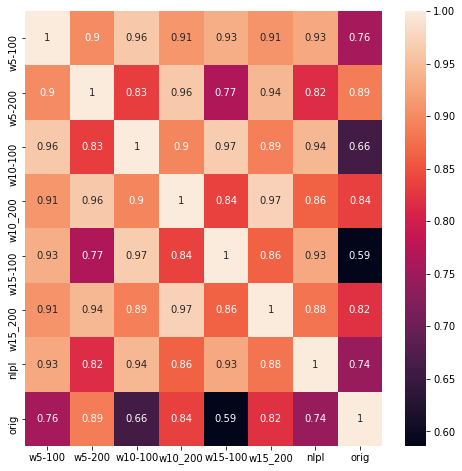

In [109]:
dfs = []

df_w5 = data2data(
    iod_data = fb_sgns_w5_iod, 
    lsc_data = sgns_lsc_w5, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w5[dep].rename("w5-100"))

df_w5_200 = data2data(
    iod_data = fb_sgns_w5_200_iod, 
    lsc_data = sgns_lsc_w5_200, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w5_200[dep].rename("w5-200"))

df_w10= data2data(
    iod_data = fb_sgns_w10_iod, 
    lsc_data = sgns_lsc_w10, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w10[dep].rename("w10-100"))

df_w10_200 = data2data(
    iod_data = fb_sgns_w10_200_iod, 
    lsc_data = sgns_lsc_w10_200, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w10_200[dep].rename("w10_200"))

df_w15= data2data(
    iod_data = fb_sgns_w15_iod, 
    lsc_data = sgns_lsc_w15, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w15[dep].rename("w15-100"))

df_w15_200 = data2data(
    iod_data = fb_sgns_w15_200_iod, 
    lsc_data = sgns_lsc_w15_200, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w15_200[dep].rename("w15_200"))

df_nlpl= data2data(
    iod_data = fb_sgns_iod_nlpl, 
    lsc_data = sgns_lsc_nlpl, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_nlpl[dep].rename("nlpl"))

df_orig= data2data(
    iod_data = sgns_iod, 
    lsc_data = sgns_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_orig[dep].rename("orig"))

plt.figure(figsize=(8,8))
sns.heatmap(pd.concat(dfs, axis=1).corr(), annot=True)
plt.show()

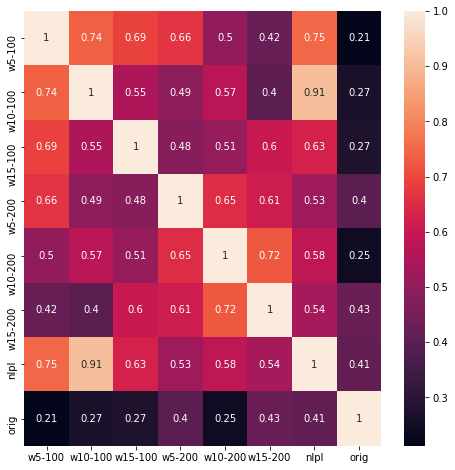

In [49]:
dfs = []
V = "cnt-ssc_dif"
df_w5 = data2data(
    iod_data = fb_sgns_w5_iod, 
    lsc_data = sgns_lsc_w5, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w5[V]).rename("w5-100"))

df_w10= data2data(
    iod_data = fb_sgns_w10_iod, 
    lsc_data = sgns_lsc_w10, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w10[V]).rename("w10-100"))

df_w15= data2data(
    iod_data = fb_sgns_w15_iod, 
    lsc_data = sgns_lsc_w15, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w15[V]).rename("w15-100"))

df_w5_200 = data2data(
    iod_data = fb_sgns_w5_200_iod, 
    lsc_data = sgns_lsc_w5_200, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w5_200[V]).rename("w5-200"))

df_w10_200= data2data(
    iod_data = fb_sgns_w10_200_iod, 
    lsc_data = sgns_lsc_w10, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w10_200[V]).rename("w10-200"))

df_w15_200= data2data(
    iod_data = fb_sgns_w15_200_iod, 
    lsc_data = sgns_lsc_w15_200, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w15_200[V]).rename("w15-200"))

df_nlpl= data2data(
    iod_data = fb_sgns_iod_nlpl, 
    lsc_data = sgns_lsc_nlpl, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_nlpl[V]).rename("nlpl"))

df_orig= data2data(
    iod_data = sgns_iod, 
    lsc_data = sgns_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_orig[V]).rename("orig"))

plt.figure(figsize=(8,8))
sns.heatmap(pd.concat(dfs, axis=1).corr(), annot=True)
plt.show()

### BERT

In [119]:
DWE      = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng']
ABSTRAT  = {"A-Strategy":"rn"}
YEARS    = years
METHODS  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"]
BASELINE = "first"

In [129]:
data = data2data(
    iod_data = kb_iod, 
    lsc_data = kb_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

# OBS! Less of normality problem with SSC measure!!
# Obs! Log transform works! For SSC measure!! Not for SMX

indep = [
    #"adf",
    "fpc",
    #"fpm_rnk",
      "fpm_log",
#     "fpm"
]
iod_var = "cnt-ssc_dif"
indep = indep + [iod_var]
dep="gch"
data = data[indep+[dep]]
data = data.dropna()

data[iod_var] = abs(data[iod_var])
#data[iod_var] = np.log(data[iod_var])
#data["iod_sq"] = data[iod_var]**2

trim=False

if trim:
    # For SMX, the normality issue does not improve by trimming "cnt-smx_dif" in addition to "gch"
    # For SSC, it does!
    # Also, it cannot be solved by trimming "cnt-smx_dif" (alone)
    # Trimming of "gch" upto 0.77 level (SMX; 0.81 for SSC) seems the best (trimming) option
    
    #wh_var=[dep, "cnt-smx_dif"]
    wh_var=[dep, iod_var]
    #wh_var=[dep]
    #wh_var=["cnt-smx_dif"]
    
    q_levels=[0.90, 0.90]
    #q_levels=[0.81]
    
    if wh_var == "all":
        VAR_TO_TRIM = indep+[dep]
    else:
        VAR_TO_TRIM = wh_var
    for q_level, v in zip(q_levels, VAR_TO_TRIM):
        Q = data[v].quantile(q=q_level)
        print(v, q_level, round(Q, 3), "N =", len(data[data[v]>Q]))
        print(", ".join(sorted(data[data[v]>Q][v].round(3).apply(lambda x: (str(x))).tolist())))
        #Q_low = data[v].quantile(q=(1-q_level))
        data[v] = data[v].apply(lambda x: x if x<Q else Q)
        #data[v] = data[v].apply(lambda x: x if x>Q_low else Q_low)
        

#data["fpm_rnk"] = rankdata(data["fpm"], nan_policy="omit")

indep = [v for v in data.columns if v != dep]

res_bert = OLS(data, "gch", indep, transform_dep=True)#True, dep_transformer="box-cox") # dep_transformer="box-cox"
res_bert.summary()
# res

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     62.39
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           1.96e-18
Time:                        06:53:52   Log-Likelihood:                 30.322
No. Observations:                  64   AIC:                            -52.64
Df Residuals:                      60   BIC:                            -44.01
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.2886      0.040    -32.548      0.000      -1.368      -1.209
fpc            -0.0009      0.010     -0.092      0.927      -0.020       0.018
fpm_log        -0.1891      0.028     -6.776      0.000      -0.245      -0.133
cnt-ssc_dif    20.6385      2.129      9.695      0.000      16.380      24.897
==============================================================================
Omnibus:                        4.810   Durbin-Watson:                   1.223
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                3.887
Skew:                           0.494   Prob(JB):                        0.143
Kurtosis:                       3.693   Cond. No.                         232.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
data = data2data(
    iod_data = kb_iod, 
    lsc_data = kb_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

# OBS! Less of normality problem with SSC measure!!
# Obs! Log transform works! For SSC measure!! Not for SMX

indep = [
    #"adf",
    "fpc",
    #"fpm_rnk",
#       "fpm_log",
    "fpm"
]
iod_var = "cnt-ssc_dif"
indep = indep + [iod_var]
dep="gch"
data = data[indep+[dep]]
data = data.dropna()

data[iod_var] = abs(data[iod_var])
#data[iod_var] = np.log(data[iod_var])
#data["iod_sq"] = data[iod_var]**2

trim=False

if trim:
    # For SMX, the normality issue does not improve by trimming "cnt-smx_dif" in addition to "gch"
    # For SSC, it does!
    # Also, it cannot be solved by trimming "cnt-smx_dif" (alone)
    # Trimming of "gch" upto 0.77 level (SMX; 0.81 for SSC) seems the best (trimming) option
    
    #wh_var=[dep, "cnt-smx_dif"]
    wh_var=[dep, iod_var]
    #wh_var=[dep]
    #wh_var=["cnt-smx_dif"]
    
    q_levels=[0.90, 0.90]
    #q_levels=[0.81]
    
    if wh_var == "all":
        VAR_TO_TRIM = indep+[dep]
    else:
        VAR_TO_TRIM = wh_var
    for q_level, v in zip(q_levels, VAR_TO_TRIM):
        Q = data[v].quantile(q=q_level)
        print(v, q_level, round(Q, 3), "N =", len(data[data[v]>Q]))
        print(", ".join(sorted(data[data[v]>Q][v].round(3).apply(lambda x: (str(x))).tolist())))
        #Q_low = data[v].quantile(q=(1-q_level))
        data[v] = data[v].apply(lambda x: x if x<Q else Q)
        #data[v] = data[v].apply(lambda x: x if x>Q_low else Q_low)
        

#data["fpm_rnk"] = rankdata(data["fpm"], nan_policy="omit")

indep = [v for v in data.columns if v != dep]

res_bert_nolog = OLS(data, "gch", indep, transform_dep=True)#True, dep_transformer="box-cox") # dep_transformer="box-cox"
res_bert_nolog.summary()
# res

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     48.03
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           5.94e-16
Time:                        06:44:08   Log-Likelihood:                 24.191
No. Observations:                  64   AIC:                            -40.38
Df Residuals:                      60   BIC:                            -31.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3610      0.038    -35.974      0.000      -1.437      -1.285
fpc            -0.0002      0.011     -0.017      0.986      -0.021       0.021
fpm            -0.0051      0.001     -5.239      0.000      -0.007      -0.003
cnt-ssc_dif    21.5932      2.324      9.290      0.000      16.944      26.242
==============================================================================
Omnibus:                        1.539   Durbin-Watson:                   1.031
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.490
Skew:                           0.274   Prob(JB):                        0.475
Kurtosis:                       2.491   Cond. No.                     3.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [144]:
models = [
    res_sgns_w5_100,
    res_sgns_w10_100,
    res_sgns_w15_100,
    res_sgns_w5_200,
    res_sgns_w10_200,
    res_sgns_w15_200,
    res_sgns_nlpl,
    res_bert
]

names = [
    "SGNS-w5-100",
    "SGNS-w10-100",
    "SGNS-w15-100",
    "SGNS-w5-200",
    "SGNS-w10-200",
    "SGNS-w15-200",
    "SGNS-nlpl",
    "SBERT"
]

ziggy = Stargazer(models)
ziggy.custom_columns(names)#, [1, 1])
ziggy.show_model_numbers(False)
ziggy.covariate_order(sorted(indep)+["const"])
ziggy.rename_covariates({'cnt-ssc_dif': 'Dif. IOD Ratio', 'fpc':'Dif. FPM (\%)', 'fpm_log': 'FPM (lg)' })
ziggy.significance_levels([0.05, 0.01, 0.001])
# ziggy
print(ziggy.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{8}{c}{\textit{Dependent variable: gch}} \
\cr \cline{2-9}
\\[-1.8ex] & \multicolumn{1}{c}{SGNS-w5-100} & \multicolumn{1}{c}{SGNS-w10-100} & \multicolumn{1}{c}{SGNS-w15100} & \multicolumn{1}{c}{SGNS-w5-200} & \multicolumn{1}{c}{SGNS-w10-200} & \multicolumn{1}{c}{SGNS-w15-200} & \multicolumn{1}{c}{SGNS-nlpl} & \multicolumn{1}{c}{SBERT}  \\
\hline \\[-1.8ex]
 Dif. IOD Ratio & 1.702$^{*}$ & 1.031$^{}$ & 1.456$^{*}$ & 1.522$^{*}$ & 1.018$^{}$ & 1.638$^{**}$ & 1.606$^{*}$ & 20.638$^{***}$ \\
& (0.710) & (0.695) & (0.649) & (0.584) & (0.586) & (0.528) & (0.708) & (2.129) \\
 Dif. FPM (%) & 0.015$^{*}$ & 0.013$^{}$ & 0.011$^{}$ & 0.014$^{*}$ & 0.011$^{}$ & 0.010$^{}$ & 0.014$^{*}$ & -0.001$^{}$ \\
& (0.007) & (0.007) & (0.006) & (0.006) & (0.006) & (0.006) & (0.006) & (0.010) \\
 FPM (lg) & 0.016$^{}$ & -0.005$^{}$ & -0.011$^{}$ & 0.064$^{***}$ & 0.045$^{*}$ & 0.039$

<Axes: >

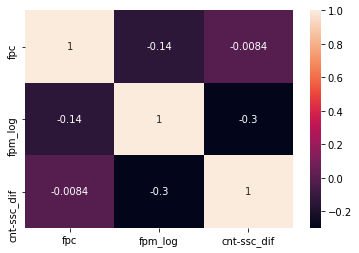

In [111]:
sns.heatmap(data[indep].corr(), annot=True)

<Axes: ylabel='Count'>

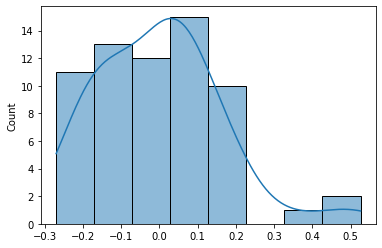

In [112]:
sns.histplot(res_bert.resid, kde=True)

In [ ]:
#data["cnt-smx_dif"].corr(data["gch"])

In [ ]:
#0.7837510127879611**2

In [ ]:
#data["cnt-smx_dif"].corr((data["gch"])**-0.39)

In [ ]:
#-0.67 * -0.67

In [ ]:
sns.heatmap(data[indep].corr(), annot=True)

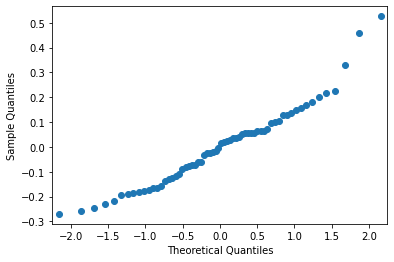

In [113]:
fig = sm.qqplot(res_bert.resid)
plt.show()

<Axes: ylabel='Count'>

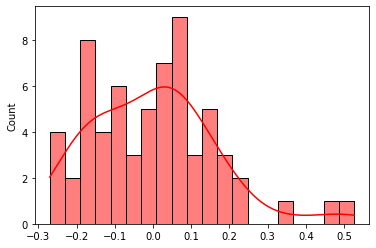

In [114]:
sns.histplot(res_bert.resid, bins=20,kde=True,color='red')

In [83]:
pg.normality(res_bert.resid, method="shapiro")

,W,pval,normal
0,0.979913,0.381195,True


<Axes: xlabel='gch', ylabel='Count'>

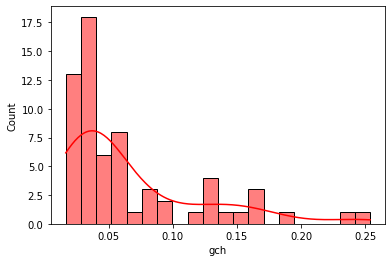

In [84]:
sns.histplot(data["gch"],bins=20,kde=True,color='red')

<Axes: xlabel='cnt-ssc_dif', ylabel='Count'>

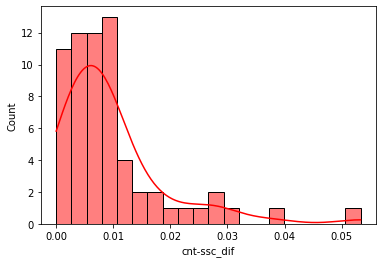

In [85]:
sns.histplot(data["cnt-ssc_dif"],bins=20,kde=True,color='red')

In [ ]:
#sns.histplot((data["gch"])**-0.3947964,bins=20,kde=True,color='red')

In [ ]:
#C = pd.concat([data["gch"], ((data["gch"])**-0.3947964).rename("bc_gch")], axis=1); C

In [ ]:
#C.corr(method="spearman")

Obs!
```
data = data2data(
    iod_data = kb_iod, 
    lsc_data = kb_lsc, 
#     dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
    baseline = "first"
)
#data["fpm_rnk"] = rankdata(data["fpm"], nan_policy = "omit")

data["cnt-smx_dif"] = abs(data["cnt-smx_dif"])
res = OLS(data, "gch", ["cnt-smx_dif", "adf", "fpm"], transform_dep=True, dep_transformer="box-cox")
res.summary()
```

```
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     29.78
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           6.43e-12
Time:                        11:52:45   Log-Likelihood:                -61.630
No. Observations:                  64   AIC:                             131.3
Df Residuals:                      60   BIC:                             139.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1333      0.156     -0.857      0.395      -0.444       0.178
cnt-smx_dif    93.5548     14.857      6.297      0.000      63.836     123.273
adf            -0.0048      0.010     -0.502      0.617      -0.024       0.014
fpm            -0.0172      0.004     -4.305      0.000      -0.025      -0.009
==============================================================================
Omnibus:                        2.932   Durbin-Watson:                   0.899
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                2.074
Skew:                           0.336   Prob(JB):                        0.354
Kurtosis:                       3.570   Cond. No.                     5.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

```

##### Parameter search for winsoring and ...

In [ ]:
data = data2data(
    iod_data = kb_iod, 
    lsc_data = kb_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
    baseline = "first"
)
indep = [
    "cnt-smx_dif", 
    #"adf",
    "fdf",
    #"fpm_rnk",
    #"fpm_log",
    "fpm"
]
dep="gch"
data = data[indep+[dep]]
data = data.dropna()

data["cnt-smx_dif"] = abs(data["cnt-smx_dif"]) 

#wh_var = "cnt-smx_dif"
wh_var = dep

data[wh_var].plot.hist(title=wh_var)
plt.show()

q_level=0.75

Q = data[wh_var].quantile(q=q_level)
print(len(data[data[wh_var]>Q]), Q)
data[wh_var] = data[wh_var].apply(lambda x: x if x<Q else Q)

#transformer = RobustScaler(with_centering=True, quantile_range=(100-(q_level*100), q_level*100))
#v_trans = transformer.fit_transform(data[wh_var].values.reshape(-1,1)).flatten()
#data[wh_var] = v_trans

#data["fpm_rnk"] = rankdata(data["fpm"], nan_policy="omit")

res_bert = OLS(data, "gch", indep, transform_dep=False, dep_transformer="box-cox") # dep_transformer="box-cox"
res_bert.summary()
# res

In [ ]:
data[wh_var].plot.hist(title=wh_var)

### Know your data - BERT

There are problems with non normal residuals of OLS models below...

* https://baotramduong.medium.com/mastering-r-75-different-ways-of-detecting-anhandling-outliers-456e22f34c00
* https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html#sphx-glr-auto-examples-preprocessing-plot-map-data-to-normal-py
* https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2018.02104/full


Both Winsorizing and BoxCox approach works. I guess windsoring is ther better option as it is easier to interpret! However, Q for cutoff is 0.77, which is rather obtrusive. 

RobustScaler -- ? It is robust to outliers; i.e. it preserves them?!

**Found an error (26 February, 2024):** `extok.json` (which is used to calculate normalised frequencies) is different for SBERT and SGNS. This result in different `fpm` for SGNS and SBERT. Possible solutions:
1. replace `extok.json` in SBERT with `extok.json` from SGNS; and re-run `create_df_mb.py`
2. replace SBERT data for frequencies with frequency data of SGNS data here
3. Both!

Done 1.

*Also note: this error has implications for results in thesis! ... as well as Boholm & Sayeed 2023!* 

In [ ]:
DWEs = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng']
#DWEs = sgns_lsc.index,
METHODs = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"]
BASELINE = "first"

In [ ]:
SGNS = data2data(
    iod_data = sgns_iod, 
    lsc_data = sgns_lsc, 
    dwes     = DWEs,
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = METHODs,
    baseline = BASELINE
)

In [ ]:
BERT = data2data(
    iod_data = kb_iod, 
    lsc_data = kb_lsc, 
    dwes     = DWEs,
    AB_strat = {"A-Strategy":"ms1"}, 
    years    = years,
    methods  = METHODs,
    baseline = BASELINE
)

In [ ]:
SGNS.columns

In [ ]:
for m in [SGNS, BERT]:
    for col in SGNS.columns:
        if not col.endswith("_dif"):
            continue
        m[col] = abs(m[col])

#### Change IOD

In [ ]:
v = SGNS["cnt-smx_dif"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

In [ ]:
v = BERT["cnt-smx_dif"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

#### LSC

In [ ]:
v = SGNS["gch"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

In [ ]:
v = BERT["gch"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

#### Frequency

In [ ]:
len(SGNS["fpm"].dropna())

In [ ]:
SGNS["fpm"].dropna().plot()

In [ ]:
v = SGNS["fpm"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

In [ ]:
v = BERT["fpm"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

In [ ]:
v = SGNS["fpm_log"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

In [ ]:
#np.log10(SGNS["fpm"]).hist()

In [ ]:
#plt.hist(power_transform(SGNS["fpm"].values.reshape(-1,1), method="box-cox"))

In [ ]:
#plt.hist(power_transform(SGNS["fpm_log"].values.reshape(-1,1), method="yeo-johnson"))

In [ ]:
v = BERT["fpm_log"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

### Experiments with transformations

#### Orig. 

In [ ]:
var = "cnt-smx_dif"
model = BERT

In [ ]:
x = model[var].dropna()
plt.boxplot(x)
plt.show()

In [ ]:
pg.normality(x)

#### Box-Cox

In [ ]:
x = model[var].dropna()
x = power_transform(x.values.reshape(-1,1), method="box-cox").flatten()
x = pd.Series(x.flatten())
print(pg.normality(x)["W"].values[0], pg.normality(x)["normal"].values[0])
plt.boxplot(x)
plt.show()

In [ ]:
x.hist()

#### Quantile stuff

In [ ]:
x = model[var].dropna()
x.plot.box()
plt.show()
#transformer = QuantileTransformer(n_quantiles=60, output_distribution='normal') # basically ranking?
transformer =  RobustScaler(with_centering=True, unit_variance=False, quantile_range=(25, 75)) # quantile_range=(0.1, 0.9)
x = transformer.fit_transform(x.values.reshape(-1,1))
x = pd.Series(x.flatten())
plt.boxplot(x)
plt.show()

In [ ]:
x.max() #?????

In [ ]:
results = []
for value in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    transformer = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(value, 100-value))
    gch = model[var].dropna()
    gch = gch.values.reshape(-1,1)
    gch_trans = transformer.fit_transform(gch)
    gch_trans = gch_trans.flatten()
#     gch_trans = np.log(gch_trans)
    gch_trans = pd.Series(gch_trans, name=value)
    normal = pg.normality(gch_trans)
    normal["Median"] = gch_trans.median()
    normal["Max"] = gch_trans.max()
    normal["Min"] = gch_trans.min()
    normal["Range"] = normal["Max"] - normal["Min"]
    
    results.append(normal)
pd.concat(results)

In [ ]:
x.hist()

In [ ]:
pg.normality(x)

In [ ]:
x = model[var].dropna()
for k in range(1,60):
    transformer = QuantileTransformer(n_quantiles=k, output_distribution='normal') # basically ranking?
    #transformer =  RobustScaler(quantile_range=(0.3, 0.7))
    t = transformer.fit_transform(x.values.reshape(-1,1))
    t = pd.Series(t.flatten())
    print(k, pg.normality(t)["W"].values[0], pg.normality(t)["normal"].values[0])

#### BoxCox Transform GCH

How to interpret the results?!

##### SGNS

In [ ]:
SGNS["gch"].hist()

In [ ]:
pg.normality(SGNS["gch"])

In [ ]:
x = SGNS["gch"].dropna()
x = power_transform(x.values.reshape(-1,1), method="box-cox").flatten()
plt.hist(x)
plt.show

In [ ]:
pg.normality(x)

##### BERT

In [ ]:
BERT["gch"].hist()

In [ ]:
pg.normality(BERT["gch"])

In [ ]:
x = SGNS["gch"].dropna()
x = power_transform(x.values.reshape(-1,1), method="box-cox").flatten()
plt.hist(x)
plt.show

In [ ]:
pg.normality(x)

## Are the methods of measurement different?

* ***dif***<sub>*strategy*, *year*</sub> = `cnt` - `pwn`
* ***Mean***(*dif*)
* ***Min***(*dif*)
* ***Max***(*dif*)
* ***SD***(*dif*)
* ***correlation***(`cnt`, `pwn`)
* ***Overall*** vs. ***per term***

In [ ]:
def get_difs(df, M, years, corr):
    
    m1, m2 = M
    difs = []
    for year in years:
        #print(df[df["Method"] == m1][year])
        x = df[df["Method"] == m1][year].values[0]
        y = df[df["Method"] == m2][year].values[0]
        #dif = x - y
        dif = max(x,y) - min(x,y)
        
        #print(dif)
        
#         dif = dif.values.flatten().tolist()
        
        #print(dif)
        
        difs.append(dif)
        
    X = df[df["Method"]==m1][years].values.flatten()
    Y = df[df["Method"]==m2][years].values.flatten()
#     print(X)
#     print(Y)
    X, Y = zip(*[(x, y) for x,y in zip(X, Y) if not (pd.isna(x) or pd.isna(y))])
    
#     print(X)
#     print(Y)

    stat = corr(X, Y)
    r = stat.statistic
    N = len(X)
    
    return r, N, difs
    

In [ ]:
def compare_measures(iod_data, measures, years, corr = pearsonr, dwes = "all", aggregate = 1):
    """
    Compare measurement methods:
    param  iod_data   dataframe
    param  measures   tuple of measures, e.g. ("I-cnt", "I-pwn")
    param  aggregate  ... 
    """
    
    m1, m2 = measures
    
    if dwes == "all":
        dwes = set(iod_data["DWE"].values)
    else:
        assert isinstance(dwes, (list, tuple, set)), "`dwes` not iterable"
    
    dwes = list(dwes)
    dwes.sort()
    
    AB_strategies = sorted([col for col in iod_data.columns if col.lower().endswith("strategy")])
    if len(AB_strategies) == 1:
        strategies = list(set(iod_data[AB_strategies[0]].values))
    if len(AB_strategies) == 2:
#         print("AB", AB_strategies)
        A_strat = sorted(list(set(iod_data[AB_strategies[0]].values))) 
        B_strat = sorted(list(set(iod_data[AB_strategies[1]].values)))
        strategies = []
        for a in A_strat:
            for b in B_strat:
#                 print(a, b)
                strategies.append(f"{a}-{b}")
    
    
    if aggregate == 0:
        d = {dwe: {strategy: {"dif": None, "r": None} for strategy in strategies} for dwe in dwes}
    if aggregate == 1:
        d = {dwe: {"dif": [], "r": []} for dwe in dwes}
    if aggregate == 2:
        d = {"dif": [], "r": []}
    
    for dwe in dwes:
        
        if len(AB_strategies) == 1:
#             strategy = AB_strategies[0]
            for s in strategies:
                df = iod_data[(iod_data["DWE"] == dwe) & (iod_data["A-Strategy"] == s)]
                r, N, difs = get_difs(df, (m1, m2), years, corr)
                
                if aggregate == 0:
                    d[dwe][s]["r"] = r
                    d[dwe][s]["dif"] = difs
                    
                if aggregate == 1:
                    d[dwe]["r"].append(r)
                    d[dwe]["dif"].extend(difs)
                    
                if aggregate == 2:
                    d["r"].append(r)
                    d["dif"].extend(difs)
                
        
        if len(AB_strategies) == 2:
            
            for a in A_strat:
                for b in B_strat:
#                     print(a, b)
                    df = iod_data[(iod_data["DWE"] == dwe) & (iod_data["A-Strategy"] == a) & (iod_data["B-Strategy"] == b)]
                    r, N, difs = get_difs(df, (m1, m2), years, corr)
                    s = f"{a}-{b}"
                    #print(strategies.index(s))
                    
                    if aggregate == 0:
                        d[dwe][s]["r"] = r
                        d[dwe][s]["dif"] = difs

                    if aggregate == 1:
                        d[dwe]["r"].append(r)
                        d[dwe]["dif"].extend(difs)

                    if aggregate == 2:
                        d["r"].append(r)
                        d["dif"].extend(difs)
    
    results = []
    
    if aggregate == 0:
        for dwe in d.keys():
            for strategy in d[dwe].keys():
                dif = d[dwe][strategy]["dif"]
#                 print(d[dwe])
#                 print(d[dwe][strategy])
                to_results = {
                    "DWE" : dwe,
                    "Mdif"   : np.nanmean(dif),
                    "SDdif"  : np.nanstd(dif),
                    "MAXdif" : np.nanmax(dif),
                    "MINdif" : np.nanmin(dif),
                    "r"   : np.mean(d[dwe][strategy]["r"])
                }
                results.append(to_results)                
    if aggregate == 1:
        for dwe in d.keys():
            dif = d[dwe]["dif"]
            to_results = {
                "DWE"    : dwe,
                "Mdif"   : np.nanmean(dif),
                "SDdif"  : np.nanstd(dif),
                "MAXdif" : np.nanmax(dif),
                "MINdif" : np.nanmin(dif),
                "rM"      : np.mean(d[dwe]["r"])
            }
            results.append(to_results)
    if aggregate == 2:
        dif = d["dif"]
        to_results = {
            "DWE"    : None,
            "Mdif"   : np.nanmean(dif),
            "SDdif"  : np.nanstd(dif),
            "MAXdif" : np.nanmax(dif),
            "MINdif" : np.nanmin(dif),
            "rM"      : np.mean(d["r"])
        }
        results.append(to_results)        
        
    
    return pd.DataFrame(results)
            


## `cnt` vs. `pwn`?

### SGNS

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("I-cnt", "I-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("O-cnt", "O-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_globalist`! A frequency effect?

### KB

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("I-cnt", "I-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("O-cnt", "O-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

### STS

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("I-cnt", "I-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("O-cnt", "O-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

**Summary:** Values of `cnt` and `pwn` are different, but *very* strongly correlated. The only exception is:

* SGNS-model
* Outgroup-dimension
* *globalist*

Here the correlation is 0.6 instead of 1.0. *Why?* (What is the "conceptual" difference between `cnt` and `pwn`? Consider Hamilton et al.).

## `ssc` vs. `smx`?

### SGNS

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("cnt-ssc", "cnt-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_kulturberikare`

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("pwn-ssc", "pwn-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Again, note: `N1_kulturberikare`, `V1_berika`

### STS

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("cnt-ssc", "cnt-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("pwn-ssc", "pwn-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

### KB

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("cnt-ssc", "cnt-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_globalist`

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("pwn-ssc", "pwn-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_globalist`

**Summary:** Values of `ssc` and `smx` are different, but very strongly correlated. Exceptions are:

|     |      `ssc`     |             `smx`          |
|-----|----------------|----------------------------|
|SNGS |*kulturberikare*|*kulturberikare*, *berikare*|
|KB   |*globalist*     |*globalist*                 |

*When less strongly correlated, why?* What is the "conceptual" difference between `ssc` and `smx`? Look at time plots. `smx` seems less variable, while `ssc` is more "responsive" to big gaps between ingroup and outgroup dimension.

## Visualization

In [ ]:
def viz(
    iod_data, 
    dwe, 
    criterion, 
    years, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True
):
    
    df = iod_data.copy()
    df = df[df["DWE"] == dwe]
    for col, val in criterion.items():
        df = df[df[col] == val]
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    for m, c, l in meas:
        X = df[(df["DWE"] == dwe) & (df["Method"] == m)][years]
        if truncate:
            x, y = zip(*[(x, y) for x, y in zip(X.columns, X.values.flatten()) if not pd.isna(x) and not pd.isna(y)])
        else: 
            x = X.columns
            y = X.values.flatten()
            
        ax.plot(x, y, label=m, c=c, linestyle=l)
    ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncols=2)

    
    plt.show()
    
    

In [ ]:
def viz_multi(
    title,
    iod_data_frames,
    names,
    dwes, 
    criteria, 
    years, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    ncols = 2
):
    
    dfs = []
    for D, criterion, dwe in zip(iod_data_frames, criteria, dwes):
        df = D.copy()
        df = df[df["DWE"] == dwe]
        for col, val in criterion.items():
            df = df[df[col] == val]
        dfs.append(df)

    NROWS  = ceil(len(dfs) / ncols)
    NCOLS  = ncols
    WIDTH  = 12 * NCOLS
    HEIGTH = NROWS * 6 
    
#    Y = years[[len(y) for y in years].index(max([len(y) for y in years]))]
#    Y = [int(y) for y in Y]
    
    fig, axs = plt.subplots(NROWS, NCOLS, figsize=(WIDTH,HEIGTH))

    for df, ax, yrs, name in zip(dfs, axs.flatten(), years, names):
        for m, c, l in meas:
#             X = df[(df["DWE"] == dwe) & (df["Method"] == m)][yrs]
            X = df[df["Method"] == m][yrs]
            
            if truncate:
                x, y = zip(*[(x, y) for x, y in zip(X.columns, X.values.flatten()) if not pd.isna(x) and not pd.isna(y)])
            else: 
                x = [int(c) for c in X.columns]
                y = X.values.flatten()

            ax.plot(x, y, label=m, c=c, linestyle=l)
            ax.set_title(name, fontsize=15)
            ax.set_xticks(range(len(x)))
            ax.set_xticklabels(x, rotation=35)#, ha='right')
            #ax.set_xticks(range(len(Y)+1), labels=Y)
        #ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncols=2)
            ax.legend()

    fig.suptitle(title, fontsize=25)
    plt.show()
    
    

### SGNS

In [ ]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
viz_multi(
    title = "SGNS: Flashback",
    iod_data_frames = [sgns_iod]*4, 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*4,  
    years = [years]*4, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_globalist", "N1_globalist"]
viz_multi(
    title = "SGNS: globalist -- original & recoded",
    iod_data_frames = [sgns_iod, fb_sgns_G_iod], 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
    years = [years]*2, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_globalist", "N1_globalist"]
viz_multi(
    title = "SGNS: globalist -- original & recoded",
    iod_data_frames = [sgns_iod, fb_sgns_G_iod], 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"top3", "B-Strategy": "lazy"}]*2,  
    years = [years]*2, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_globalist", "N1_globalist"]
viz_multi(
    title = "SGNS: globalist -- original & recoded",
    iod_data_frames = [fm_sgns_iod, fm_sgns_G_iod], 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
    years = [fm_years]*2, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

**Why has `O-cnt` changed??? Does not make any sense!**

In [ ]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
viz_multi(
    title = "SGNS: Flashback",
    iod_data_frames = [sgns_iod, fb_sgns_G_iod, sgns_iod, sgns_iod], 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*4,  
    years = [years]*4, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
viz_multi(
    title = "SGNS: Flashback",
    iod_data_frames = [sgns_iod]*4, 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*4,  
    years = [years]*4, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-smx", "b", '--')], 
    truncate = True)

In [ ]:
# viz_multi(
#     title = "SGNS: Flashback",
#     iod_data_frames = [sgns_iod]*4, 
#     names = ["V1_berika", "V1_kulturberika", "N1_berikare", "N1_kulturberikare"],
#     dwes = ["V1_berika", "V1_kulturberika", "N1_berikare", "N1_kulturberikare"], 
#     criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*4,  
#     years = [years]*4, 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

In [ ]:
viz_multi(
    title = "SGNS: Flashback",
    iod_data_frames = [sgns_iod]*2, 
    names = ["V1_återvandra", "N1_återvandring"],
    dwes = ["V1_återvandra", "N1_återvandring"], 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
    years = [years]*2, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_återvandring","N1_globalist","V1_berika"]*2

NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback"]*3 + ["Familjeliv"]*3)]
#print(NAMES)

viz_multi(
    title = "SGNS",
    iod_data_frames = [sgns_iod]*3 + [fm_sgns_iod]*3, 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*6,  
    years = [years]*3 + [fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    ncols = 3
)

In [ ]:
DWES = ["N1_återvandring"]*2+["N1_globalist"]*2+["V1_berika"]*2
NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback", "Familjeliv"]*3)]
#print(NAMES)

viz_multi(
    title = "SGNS",
    iod_data_frames = [sgns_iod, fm_sgns_iod]*3, 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*6,  
    years = [years, fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_återvandring"]*2+["N1_globalist"]*2+["V1_berika"]*2
NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback", "Familjeliv"]*3)]
#print(NAMES)

viz_multi(
    title = "SGNS",
    iod_data_frames = [sgns_iod, fm_sgns_iod] + [fb_sgns_G_iod, fm_sgns_G_iod,] + [sgns_iod, fm_sgns_iod], 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*6,  
    years = [years, fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
# viz_multi(
#     title = "SGNS: återvandring",
#     iod_data_frames = [sgns_iod, fm_sgns_iod], 
#     names = ["Flashback", "Familjeliv"],
#     dwes = ["N1_återvandring"]*2, 
#     criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
#     years = [years, fm_years], 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

In [ ]:
# viz_multi(
#     title = "SGNS: globalist",
#     iod_data_frames = [sgns_iod, fm_sgns_iod], 
#     names = ["Flashback", "Familjeliv"],
#     dwes = ["N1_globalist"]*2, 
#     criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
#     years = [years, fm_years], 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

In [ ]:
# viz_multi(
#     title = "SGNS: globalist",
#     iod_data_frames = [sgns_iod, fm_sgns_iod], 
#     names = ["Flashback", "Familjeliv"],
#     dwes = ["N1_globalist"]*2, 
#     criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
#     years = [years, fm_years], 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

### KB

In [ ]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
viz_multi(
    title = "SBERT (KB, rn)",
    iod_data_frames = [kb_iod]*4, 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*4,  
    years = [years]*4, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_globalist", "N1_globalist"]
viz_multi(
    title = "globalist: original & recoded:  FB, SBERT (KB, rn): ",
    iod_data_frames = [kb_iod, fb_kb_G_iod], 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*2,  
    years = [years]*2, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

**Here, `O-cnt` are identical!**

In [ ]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
viz_multi(
    title = "SBERT (KB, top3)",
    iod_data_frames = [kb_iod]*4, 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"top3"}]*4,  
    years = [years]*4, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
# DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
# viz_multi(
#     title = "SBERT (KB, ms1)",
#     iod_data_frames = [kb_iod]*4, 
#     names = DWES,
#     dwes = DWES, 
#     criteria = [{"A-Strategy":"ms1"}]*4,  
#     years = [years]*4, 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

In [ ]:
DWES = ["N1_återvandring","N1_globalist","V1_berika"]*2

NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback"]*3 + ["Familjeliv"]*3)]
#print(NAMES)

viz_multi(
    title = "SBERT (KB)",
    iod_data_frames = [kb_iod]*3 + [fm_kb_iod]*3, 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*6,  
    years = [years]*3 + [fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    ncols = 3
)

In [ ]:
DWES = ["N1_återvandring"]*2+["N1_globalist"]*2+["V1_berika"]*2
NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback", "Familjeliv"]*3)]

viz_multi(
    title = "",
    iod_data_frames = [kb_iod, fm_kb_iod]*3, 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*6,  
    years = [years, fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    ncols = 2
)

In [ ]:
# DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
# viz_multi(
#     title = "SBERT (STS)",
#     iod_data_frames = [sts_iod]*4, 
#     names = DWES,
#     dwes = DWES, 
#     criteria = [{"A-Strategy":"rn"}]*4,  
#     years = [years]*4, 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

In [ ]:
#viz(sgns_iod, "N1_återvandring", {"A-Strategy":"ms1", "B-Strategy": "top3"}, years)

In [ ]:
#viz(fm_sgns_iod, "N1_återvandring", {"A-Strategy":"ms1", "B-Strategy": "top3"}, fm_years)

In [ ]:
#viz(sts_iod, "N1_återvandring", {"A-Strategy":"ms1"}, years)

In [ ]:
#viz(sgns_iod, "N1_förortsgäng", {"A-Strategy":"ms1", "B-Strategy": "top3"}, years)

In [ ]:
#viz(sts_iod, "N1_förortsgäng", {"A-Strategy":"top3"}, years)

In [ ]:
#viz(sgns_iod, "N1_globalist", {"A-Strategy":"ms1", "B-Strategy": "top3"}, years)

In [ ]:
#viz(sts_iod, "N1_globalist", {"A-Strategy":"top3"}, years)

In [ ]:
#viz(sgns_iod, "V1_berika", {"A-Strategy":"ms1", "B-Strategy": "top3"}, years)

In [ ]:
#viz(kb_iod, "V1_berika", {"A-Strategy":"ms1"}, years)

In [ ]:
#viz(sgns_iod, "N1_berikare", {"A-Strategy":"ms1", "B-Strategy": "top3"}, years)

In [ ]:
#viz(sts_iod, "N1_berikare", {"A-Strategy":"rn"}, years)

## ... ingroupness in FB and  FL

In [ ]:
fm_sgns_lsc.index

In [ ]:
def t(iodA, yA, iodB, yB, dwes, criterion, method, collapse = False, ks=False, drop_from_results=["alternative","BF10", "power"]):
    
    dfA = iodA.copy()
    dfB = iodB.copy()
    
    criterion["Method"] = method
    
    for var, val in criterion.items():
        dfA = dfA[dfA[var]==val]
        dfB = dfB[dfB[var]==val]
    
    dfA.set_index("DWE", inplace=True)
    dfB.set_index("DWE", inplace=True)
    
    dfA = dfA.loc[dwes]
    dfB = dfB.loc[dwes]
    
    dfA = dfA[yA]
    dfB = dfB[yB]
    
    if collapse:
        A = dfA.values.flatten()
        B = dfB.values.flatten()
        if ks:
            return ks_2samp(A,B)
        results = pg.ttest(A,B)
        for exclude in drop_from_results:
            results.drop(exclude, axis=1, inplace=True)
            
        results["M_A"] = np.nanmean(A) 
        results["M_B"] = np.nanmean(B)
        results["N_A"] = len([a for a in A if not pd.isna(a)])
        results["N_B"] = len([b for b in B if not pd.isna(b)])
        return results
    else:
        results = []
        for dwe in dwes:
            A = dfA.loc[dwe].values.flatten()
            B = dfB.loc[dwe].values.flatten()
            result = pg.ttest(A,B)
            for exclude in drop_from_results:
                result.drop(exclude, axis=1, inplace=True)
            
            result["Term"] = dwe
            result["M_A"] = np.nanmean(A)
            result["sd_A"] = np.nanstd(A)
            result["N_A"] = len([a for a in A if not pd.isna(a)])
            result["M_B"] = np.nanmean(B)
            result["sd_B"] = np.nanstd(B)            
            result["N_B"] = len([b for b in B if not pd.isna(b)])
            results.append(result)
        results = pd.concat(results)
        results.set_index("Term", inplace=True)
        return results.round(3)
            
    

### SGNS

In [ ]:
results = t(
    sgns_iod, 
    years, 
    fm_sgns_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "cnt-smx",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

In [ ]:
results = t(
    fb_sgns_G_iod, 
    years, 
    fm_sgns_G_iod, 
    fm_years, 
    ["N1_globalist"], 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "cnt-smx",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

In [ ]:
results = t(
    fb_sgns_G_iod, 
    years, 
    fm_sgns_G_iod, 
    fm_years, 
    ["N1_globalist"], 
    {"A-Strategy":"top3", "B-Strategy": "min0.2"},
    "I-cnt",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

For every combination, GLOABLIST is more ingroup in familjeliv! 

In [ ]:
t(
    sgns_iod, 
    years, 
    fm_sgns_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "cnt-ssc",
    collapse=False,
    #ks=True
)

In [ ]:
t(
    sgns_iod, 
    years, 
    fm_sgns_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "pwn-smx",
    collapse=False,
    #ks=True
)

**Obs!** `V1_återvandra`

In [ ]:
t(
    sgns_iod, 
    years, 
    fm_sgns_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "pwn-ssc",
    collapse=False,
    #ks=True
)

**Obs!** `V1_återvandra`

### KB

In [ ]:
set(kb_iod["A-Strategy"])

In [ ]:
results = t(
    kb_iod, 
    years, 
    fm_kb_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"rn"},
    "cnt-smx",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

In [ ]:
results = t(
    kb_iod, 
    years, 
    fm_kb_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1"},
    "cnt-ssc",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

In [ ]:
# results = t(
#     fb_kb_G_iod, 
#     years, 
#     fm_kb_G_iod, 
#     fm_years, 
#     fm_sgns_lsc.index, 
#     {"A-Strategy":"rn"},
#     "cnt-smx",
#     collapse=False,
#     #ks=True
# )
# #print(results.to_latex(float_format="{:.3f}".format))
# results

In [ ]:
t(
    kb_iod, 
    years, 
    fm_kb_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"rn"},
    "cnt-ssc",
    collapse=False,
    #ks=True
)

In [ ]:
t(
    kb_iod, 
    years, 
    fm_kb_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"rn"},
    "pwn-smx",
    collapse=False,
    #ks=True
)

In [ ]:
t(
    fb_kb_G_iod, 
    years, 
    fm_kb_G_iod, 
    fm_years, 
    ["N1_globalist"], 
    {"A-Strategy":"ms1"},
    "pwn-ssc",
    collapse=False,
    #ks=True
)

## Correlation

In [ ]:
d = sgns_iod[sgns_iod["DWE"] == "V1_berika"][years].transpose().corr()

plt.imshow(d, cmap=plt.cm.rainbow, interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
def compare(iod_data, term, criterion, method=pearsonr, years = years, add_mean=False):
    
    used = years + list(criterion.keys()) + ["DWE"]
    remains = [col for col in iod_data.columns if col not in used]
    #print(remains)

    df = iod_data.copy()
    df = df[df["DWE"] == term]
    
    if type(criterion) == dict:
        criterion = criterion.items()
    for var, val in criterion:
        df = df[df[var]==val]
    
    df = df[years]
    
    #return df
    
    labels = ["-".join(iod_data.loc[i][remains].to_list()) for i in df.index]
    
    df["labels"] = labels
    df = df.set_index("labels")
    
    correlations = df.transpose().corr().round(3)
    
    if add_mean:
        correlations["Mean"] = correlations.mean(axis=1)
    
    return correlations
    
#     plt.imshow(correlations, cmap=plt.cm.rainbow, interpolation='nearest')
#     plt.colorbar()
#     plt.show()
    

In [ ]:
#sgns_iod

In [ ]:
#fm_sgns_iod

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=years)

In [ ]:
# x =  fm_sgns_iod.drop("2022", axis=1)
# compare(iod_data=x, term="V1_berika", criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=fm_years)

## Correlation of Selection Strategies

### SGNS

#### Återvandring

In [ ]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"cnt-ssc"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

#### Berika

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

##### Kulturberika

In [ ]:
compare(iod_data=sgns_iod, term="V1_kulturberika", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_kulturberika", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_kulturberika", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

#### Förortsgäng

In [ ]:
compare(iod_data=sgns_iod, term="N1_förortsgäng", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_förortsgäng", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_förortsgäng", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

#### Globalist

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"cnt-ssc"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

## Correlation of *I* and *O*

Ingroup and outgroup are to a large extent correlated. For the SGNS models this is kind of expected given the semantic space the embeddings are trained in. For the SBERT-KB models this is more surprising. 

### SGNS - Flashback

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=sgns_iod, term=term, criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df1 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sgns-fb"])
df1

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=sgns_iod, term=term, criterion={"A-Strategy":"top3", "B-Strategy": "lazy"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df1 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sgns-fb"])
df1

### SGNS - Familjeliv

In [ ]:
x = fm_sgns_iod.drop("2022", axis=1)
correlations = []

for term in fm_sgns_lsc.index:
    r = compare(iod_data=x, term=term, criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=fm_years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df2 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sgns-fl"])
df2

### SBERT - Flashback

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=kb_iod, term=term, criterion={"A-Strategy":"rn"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df3 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fb"])
df3

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=kb_iod, term=term, criterion={"A-Strategy":"top3"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df3 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fb"])
df3

STS:

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=sts_iod, term=term, criterion={"A-Strategy":"rn"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df3 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fb"])
df3

### SBERT - Familjeliv

In [ ]:
#x = fm_kb_iod.drop("2022", axis=1)
correlations = []

for term in fm_sgns_lsc.index:
    r = compare(iod_data=fm_kb_iod, term=term, criterion={"A-Strategy":"rn"}, years=fm_years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df4 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fl"])
df4

In [ ]:
print(pd.concat([df1, df2, df3, df4], axis=1).to_latex(float_format="{:.3f}".format))

## Correlation external variables

In [ ]:
def correlation(
    iod_data, 
    iod_var, 
    lsc_data, 
    lsc_var, 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    only_sign = True, 
    years = years,
    difference = False,
    baseline = "first" # first or second year of pair (t_i, t_j)
):
    
    results = []
    
    if type(iod_var) == dict:
        iod_var = iod_var.items()
        
    X = iod_data.copy()
    for var, val in iod_var:
        X = X[X[var]==val]
    
    if lsc_var == "fpm":
        X = X[[str(y) for y in years]]
    else:
        if difference:
#             transitions = [f"{str(year)[2:]}:{str(int(year)+1)[2:]}" for year in years[:-1]]
            transitions = [f"{str(year)}:{str(int(year)+1)}" for year in years[:-1]]
            X = X[transitions]
        else:
            if baseline == "first":
                X = X[[str(y) for y in years[:-1]]]
            if baseline == "second":
                X = X[[str(y) for y in years[1:]]]
   
    col = [v for v in lsc_data.columns if v.startswith(lsc_var)]
    #col = [v for v in lsc_data.columns if v.startswith(lsc_var)][:-1]
    
#     for a, b, in zip(X.columns, col):
#         print(a, b)
#     print("----")
    
    idx = []
    for i in X.index:
        x = X.loc[i]
        dwe = iod_data.iloc[i]["DWE"]
        if dwe not in lsc_data.index:
            continue
        y = lsc_data.loc[dwe][col]
        
        x,y = zip(*[(a,b) for a,b in zip(x,y) if not pd.isna(a) and not pd.isna(b)])
        
        if norm_iod:
            x = norm_iod(x)
        if norm_lsc:
            y = norm_lsc(y)
            
        
        N = len(x)

        stat = method(x, y)
        
        d = {
            "Corr": stat[0],
            "p": stat[1],
            "N": N,
        }
        
        if only_sign:
            if stat[1] < 0.05:
                idx.append(i)
                results.append(d)
        else:
            idx.append(i)
            results.append(d)
    
    df = pd.DataFrame(results, index=idx)
    headings = [h for h in iod_data.columns if not any(ch.isdigit() for ch in h)]
    df = pd.concat([iod_data.loc[idx][headings], df], axis=1)
    
    return df
    

In [ ]:
def ConCat(feature, base_criterion, measures, iod, lsc, years, baseline):
    results = []
    criterion = dict(base_criterion)
    for m in sorted(measures):
        criterion["Method"] = m
        df = correlation(iod, criterion, lsc, feature, years = years, method=pearsonr, only_sign = False, baseline=baseline)
        df.set_index("DWE", inplace=True)
#         print(df)
#         break
        N = df["N"]
        df = df[["Corr", "p"]]
        df.rename({"Corr":m}, axis=1, inplace=True)
        results.append(df)
    results.append(N)
    return pd.concat(results, axis=1).round(3)

In [ ]:
#ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="first")

In [ ]:
#ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")

In [ ]:
def pwalk(
    iod_data, 
    #iod_var, 
    lsc_data, 
    lsc_var, 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05,
    add_total = True
    ):
    
    dfs = []
    
    if s_combos == "all":
        combos = []
        col = [c for c in iod_data.columns if c.lower().endswith("strategy")]
        
        if len(col) == 1:
            val = set(iod_data[col[0]].values)
            for v in val:
                for m in iod_methods:
                    combos.append({col[0]:v,"Method":m})
        if len(col) == 2:
            val1 = set(iod_data[col[0]].values)
            val2 = set(iod_data[col[1]].values)
            for v1 in val1:
                for v2 in val2:
                    for m in iod_methods:
                        combos.append({col[0]:v1, col[1]: v2, "Method":m})            
    
#    print(combos)
    
    key = {}
    
    for combo in combos:
        
        df = correlation(
            iod_data=iod_data, 
            iod_var=combo, 
            lsc_data=lsc_data, 
            lsc_var=lsc_var, 
            norm_iod=norm_iod, 
            norm_lsc=norm_lsc, 
            method=method, 
            only_sign=False, 
            years=years)
        
        #return df["p"]
        
        if binary:
            df[criterion] = df[criterion] < threshold
            df[criterion] = df[criterion].astype(int)
        
        name = "-".join([f"{var}:{val}" for var, val in combo.items()])
#         df = df[criterion]

        if list(key.values()) == []:
            key[name] = 0
        else:
            key[name] = max(key.values())+1
        
        df = df.rename({criterion: key[name]}, axis=1)
        df.set_index("DWE", inplace=True)
        df = df[key[name]]
        
        dfs.append(df)
        
    results = pd.concat(dfs, axis=1)
    if add_total:
        results.loc['Column_Total'] = results.sum(numeric_only=True, axis=0)
#         results = results.append(results.sum(numeric_only=True), ignore_index=True)
        
    
    return results, key
        
    

In [ ]:
def maximizer(df, key):
    col_idx = df.loc["Column_Total"].idxmax(axis=0)
    combo = dict([(v, k) for k, v in key.items()])
    return combo[col_idx], key[combo[col_idx]]

In [ ]:
#ConCat("gch", standard, measures_cnt + measures_pwn, fm_sgns_iod, fm_sgns_lsc, fm_years)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"top3", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "rch",
    method=pearsonr, 
    only_sign=False,
    difference = True
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "gch",
    method=pearsonr, 
    only_sign=False,
    difference = False,
    baseline="first"
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "gch",
    method=pearsonr, 
    only_sign=False,
    difference = False,
    baseline = "second"
)

## Correlation FPM

### SGNS

In [ ]:
df, key = pwalk(
    iod_data = sgns_iod, 
    #iod_var, 
    lsc_data = sgns_lsc, 
    lsc_var = "fpm", 
    norm_iod = None,
    norm_lsc = np.log10,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
df.loc[:, df.loc["Column_Total"] > 4].rename({v:k for k,v in key.items()}, axis=1)

In [ ]:
correlation(sgns_iod, {'A-Strategy':'ms1','B-Strategy':'min0.2','Method':'I-cnt'}, sgns_lsc, "fpm", norm_lsc = np.log10, method=pearsonr)

In [ ]:
correlation(sgns_iod, {"A-Strategy":"ms1", "B-Strategy":"top3",'Method':'I-cnt'}, sgns_lsc, "fpm", norm_lsc = np.log10, method=pearsonr)

In [ ]:
#

In [ ]:
fpm["DWE"].value_counts()

In [ ]:
fpm["A-Strategy"].value_counts()

In [ ]:
fpm["B-Strategy"].value_counts()

In [ ]:
fpm["Method"].value_counts()

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "fpm",
    norm_lsc = np.log10,
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "fpm", 
    norm_lsc = np.log10,
    method=pearsonr, 
    only_sign=False
)

### STS

In [ ]:
fpm = correlation(sts_iod, {}, sts_lsc, "fpm", method=pearsonr); fpm

In [ ]:
fpm["DWE"].value_counts()

In [ ]:
fpm["A-Strategy"].value_counts()

In [ ]:
fpm["Method"].value_counts()

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

### KB

In [ ]:
df, key = pwalk(
    iod_data = kb_iod, 
    #iod_var, 
    lsc_data = kb_lsc, 
    lsc_var = "fpm", 
    norm_iod = None,
    norm_lsc = np.log10,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
df

In [ ]:
fpm = correlation(kb_iod, {}, kb_lsc, "fpm", method=pearsonr); fpm

In [ ]:
fpm["DWE"].value_counts()

In [ ]:
fpm["A-Strategy"].value_counts()

In [ ]:
fpm["Method"].value_counts()

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"rn"}, 
    kb_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

## Correlation Naive Change

* Optimal method vs "standard" (`{"A-Strategy":"ms1", "B-Strategy":"top3"}` / `{"A-Strategy":"rn"}'`)
* CNT vs PWN
* O, I, ssc
* FB, FL
* SGNS, SBERT

### SGNS

#### Background

##### PWN

In [ ]:
df, key = pwalk(
    iod_data = sgns_iod, 
    #iod_var, 
    lsc_data = sgns_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-pwn", "O-pwn", "pwn-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
#df.loc[:, df.loc["Column_Total"] > 0]

##### CNT

In [ ]:
df, key = pwalk(
    iod_data = sgns_iod, 
    #iod_var, 
    lsc_data = sgns_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
#df.loc[:, df.loc["Column_Total"] > 0].rename({v:k for k,v in key.items()}, axis=1)
#df.loc[:, df.loc["Column_Total"] > 0]

#### Summary - "GCH"

In [ ]:
standard   = {"A-Strategy":"ms1",  "B-Strategy":"top3"}
opptim_pwn = {'A-Strategy':'ms1',  'B-Strategy':'min0.2'}
opptim_cnt = {'A-Strategy':'top3', 'B-Strategy':'lazy'}

measures_cnt = ["I-cnt", "O-cnt", "cnt-ssc"]
measures_pwn = ["I-pwn", "O-pwn", "pwn-ssc"]

Flashback

In [ ]:
ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")

In [ ]:
res = ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))

In [ ]:
sns.heatmap(
    ConCat(
        "gch", 
        opptim_cnt, 
        measures_cnt + measures_pwn, 
        sgns_iod, 
        sgns_lsc, 
        years, 
        baseline="second"
    ).drop(["p", "N"], axis=1),
    annot=True
)

In [ ]:
ConCat("gch", opptim_cnt, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")

In [ ]:
 ConCat("gch", opptim_pwn, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years)

Familjeliv

In [ ]:
ConCat("gch", standard, measures_cnt + measures_pwn, fm_sgns_iod, fm_sgns_lsc, fm_years, baseline="second")

In [ ]:
res = ConCat("gch", standard, measures_cnt + measures_pwn, fm_sgns_iod, fm_sgns_lsc, fm_years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))

### KB

Flashback

In [ ]:
standard = {"A-Strategy":"rn"}
res = ConCat("gch", standard, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
res = ConCat("gch", {"A-Strategy":"top1"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
res = ConCat("gch", {"A-Strategy":"rn"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

res = ConCat("gch", {"A-Strategy":"rn"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True, ax=axs[0])
axs[0].set_title("Really Naive")

res = ConCat("gch", {"A-Strategy":"top3"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True, ax = axs[1])
axs[1].set_title("Top3")

plt.show()

In [ ]:
# standard = {"A-Strategy":"rn"}
# res = ConCat("gch", standard, measures_cnt + measures_pwn, fb_kb_G_iod, kb_lsc, years, baseline="second")
# #print(res.to_latex(float_format="{:.2f}".format))
# res

Familjliv

In [ ]:
# standard = {"A-Strategy":"rn"}
# res = ConCat("gch", standard, measures_cnt + measures_pwn, fm_kb_iod, fm_kb_lsc, fm_years, baseline="second")
# print(res.to_latex(float_format="{:.2f}".format))
# res

In [ ]:
df, key = pwalk(
    iod_data = kb_iod, 
    #iod_var, 
    lsc_data = kb_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
df.loc[:, df.loc["Column_Total"] > 3].rename({v:k for k,v in key.items()}, axis=1)
#df.loc[:, df.loc["Column_Total"] > 3]

In [ ]:
correlation(kb_iod, {'A-Strategy':'top1','Method':'O-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {'A-Strategy':'top1','Method':'I-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {'A-Strategy':'rn','Method':'O-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {'A-Strategy':'rn','Method':'I-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
gch = correlation(kb_iod, {}, kb_lsc, "gch", method=pearsonr); gch

In [ ]:
gch["DWE"].value_counts()

In [ ]:
gch["A-Strategy"].value_counts()

In [ ]:
gch["Method"].value_counts()

In [ ]:
sgns_iod["A-Strategy"].value_counts()

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"rn"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"nno"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"rn"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"top3"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

### STS

In [ ]:
df, key = pwalk(
    iod_data = sts_iod, 
    #iod_var, 
    lsc_data = sts_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
#df.loc[:, df.loc["Column_Total"] > 0].rename({v:k for k,v in key.items()}, axis=1)
df.loc[:, df.loc["Column_Total"] > 4]

In [ ]:
gch = correlation(sts_iod, {}, sts_lsc, "gch", method=pearsonr); gch

In [ ]:
gch["DWE"].value_counts()

In [ ]:
gch["A-Strategy"].value_counts()

In [ ]:
gch["Method"].value_counts()

In [ ]:
sgns_iod["A-Strategy"].value_counts()

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"rn"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(2)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"top3"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
)

## Correlation Rectified Change

In [ ]:
standard   = {"A-Strategy":"ms1",  "B-Strategy":"top3"}
opptim_pwn = {'A-Strategy':'ms1',  'B-Strategy':'min0.2'}
opptim_cnt = {'A-Strategy':'top3', 'B-Strategy':'lazy'}

measures_cnt = ["I-cnt", "O-cnt", "cnt-ssc"]
measures_pwn = ["I-pwn", "O-pwn", "pwn-ssc"]

In [ ]:
res = ConCat("rch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))

In [ ]:
standard = {"A-Strategy":"rn"}
res = ConCat("rch", standard, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))
res

### SGNS

In [ ]:
rch = correlation(sgns_iod, {}, sgns_lsc, "rch", method=pearsonr); rch

In [ ]:
rch["DWE"].value_counts()

In [ ]:
rch["A-Strategy"].value_counts()

In [ ]:
rch["B-Strategy"].value_counts()

In [ ]:
rch["Method"].value_counts()

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"top3"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1", "B-Strategy":"top3"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

### STS

In [ ]:
rch = correlation(sts_iod, {}, sts_lsc, "rch", method=pearsonr); rch

In [ ]:
rch["DWE"].value_counts()

In [ ]:
rch["A-Strategy"].value_counts()

In [ ]:
rch["Method"].value_counts()

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

### KB

In [ ]:
rch = correlation(kb_iod, {}, kb_lsc, "rch", method=pearsonr); rch

In [ ]:
rch["DWE"].value_counts()

In [ ]:
rch["A-Strategy"].value_counts()

In [ ]:
rch["Method"].value_counts()

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(sgns_iod, {}, sgns_lsc, "rch", method=pearsonr)

In [ ]:
correlation(sts_iod, {}, sts_lsc, "rch", method=pearsonr)

In [ ]:
correlation(sts_iod, {"Method":"I-cnt"}, sts_lsc, "rch", method=spearmanr)

In [ ]:
correlation(kb_iod, {"Method":"cnt-ssc"}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {"Method":"O-cnt"}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(sgns_iod, {"Method":"I-cnt"}, sgns_lsc, "rch", method=pearsonr)

In [ ]:
correlation(sgns_iod, {"Method":"O-cnt"}, sgns_lsc, "gch", method=pearsonr)

### FPM

In [ ]:
fpm = sgns_lsc.loc["V1_berika"][[v for v in sgns_lsc.columns if v.startswith("fpm")]];fpm

In [ ]:
X = sgns_iod[sgns_iod["DWE"]=="V1_berika"][years];X

In [ ]:
for i in range(X.shape[0]):
    stat = pearsonr(X.loc[i], fpm)
    
    print(stat[0], stat[1])

### Change

In [ ]:
col = [v for v in sgns_lsc.columns if v.startswith("rch")]
print(len(col))
gch = sgns_lsc.loc["V1_berika"][col];gch

In [ ]:
X = sgns_iod[sgns_iod["Method"]=="cnt-ssc"][[y for y in years[:-1]]];X

In [ ]:
for i in X.index:
    x = X.loc[i]
    
    dwe = sgns_iod.iloc[i]["DWE"]
#     print(dwe)
    
    A = sgns_iod.iloc[i]["A-Strategy"]
    B = sgns_iod.iloc[i]["B-strategy"]
    
    y = sgns_lsc.loc[dwe][col]
    
    x,y = zip(*[(a,b) for a,b in zip(x,y) if not pd.isna(a) and not pd.isna(b)])
    
    stat = pearsonr(x, y)
    
    if stat[1] < 0.05:
        
        print(dwe, A, B, stat[0], stat[1])

#### Experiment

In [ ]:
from scipy.special import softmax
import random

In [ ]:
#random.seed(123)
random.seed(555)

In [ ]:
#np.random.rand(10)

In [ ]:
dim1 = np.random.rand(10)
dim2 = np.random.rand(10)

dimX = dim1 / (dim1+dim2)

In [ ]:
dim1

In [ ]:
dim2

In [ ]:
dimX

In [ ]:
pearsonr(dim1, dimX)

In [ ]:
S = np.concatenate((dim1, dim2)).reshape(2,10)

In [ ]:
dimS = softmax(S, axis=0)

In [ ]:
dimS

In [ ]:
dimS.sum(axis=0)

In [ ]:
dimS = dimS[0]

In [ ]:
dimS

In [ ]:
pearsonr(dim1, dimS)